<b>Predicting Heart Disease using K-nearest Neigbors </b>

This project focuses on training the machine using the dataset from World Health Organization(WHO) that estimates 17.9 million deaths due to Cardiovascular disease every year, to predict the likelihood of a new patient having a heart disease.

<b><u>Introduction</b></u>

In [23]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [24]:
hdp = pd.read_csv('heart_disease_prediction.csv')
hdp.head(5)
print(hdp.shape)
hdp.dtypes.value_counts()


(918, 12)


int64      6
object     5
float64    1
dtype: int64

The dataset contains 12 features(7 numerical and 5 categorical (without viewing))  and 918 observations. 

<b><u>EDA Descriptive Statistics</b></u>

In [25]:
hdp.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


We can see that the Average age of patients who are affected by a CVD is 53.
Also after carefully viewing the description, we are able to find that the categorical feature <b>Cholesterol</b> needs to be investigated as the other features don't differ much from its mean and mode while Cholesterol has a huge difference,Also ,we happen to notice that the minimum value for cholesterol is 0 which doesnt make any sense and needs to be investigated.  

<u><b>EDA Visualizations</u></b>

In [26]:
hdp.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

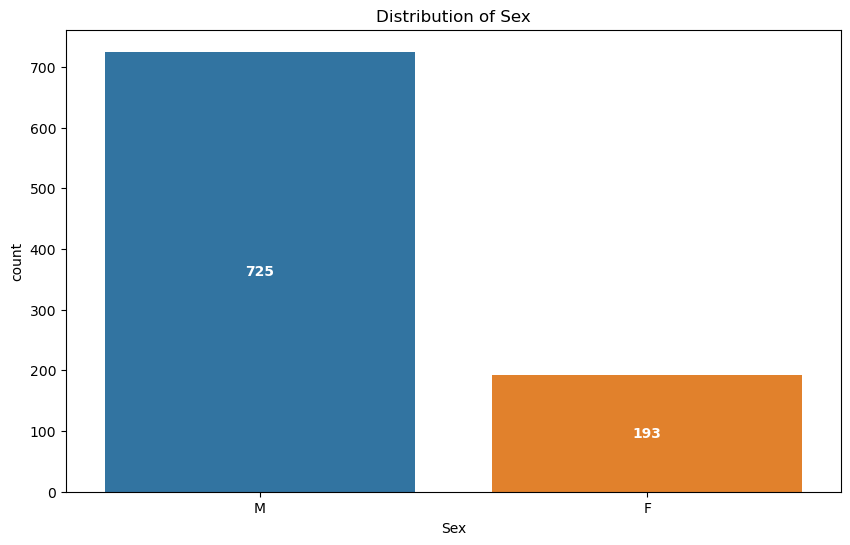

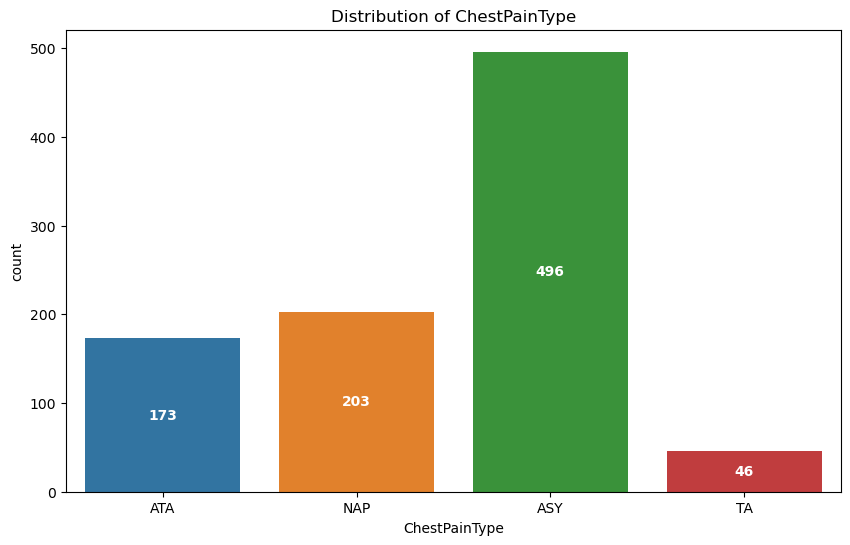

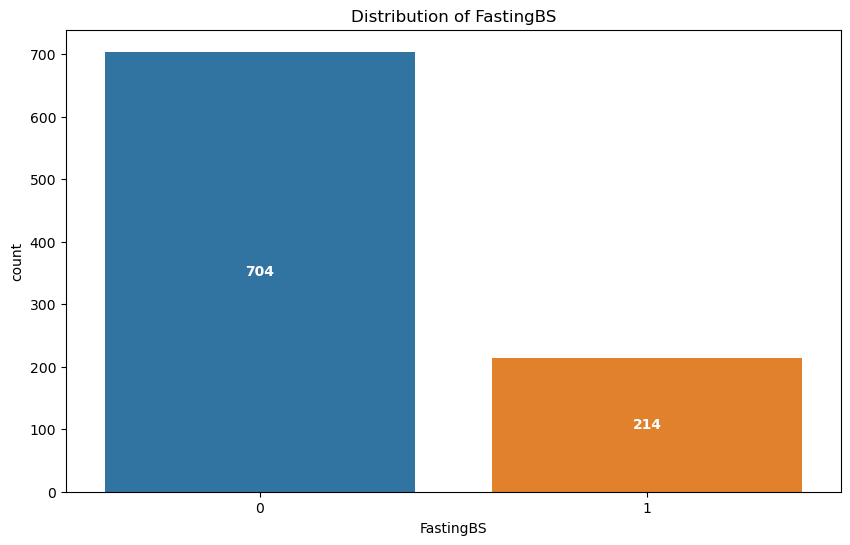

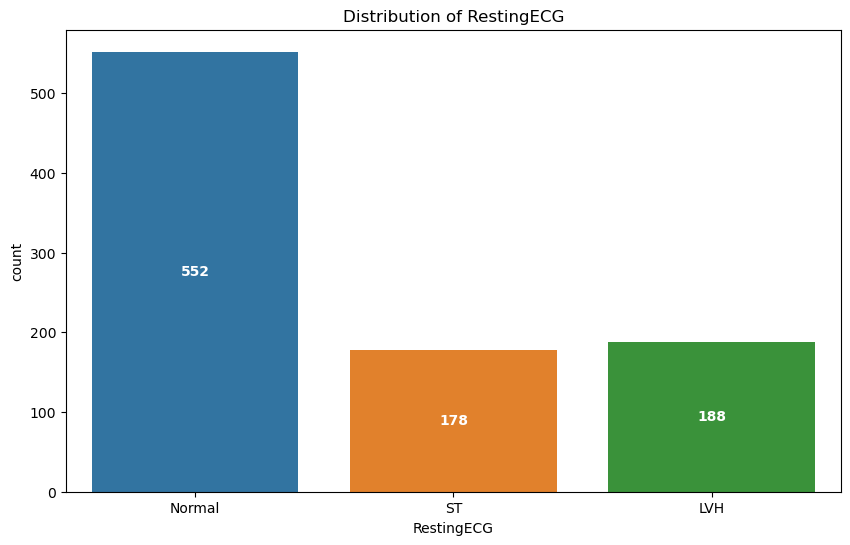

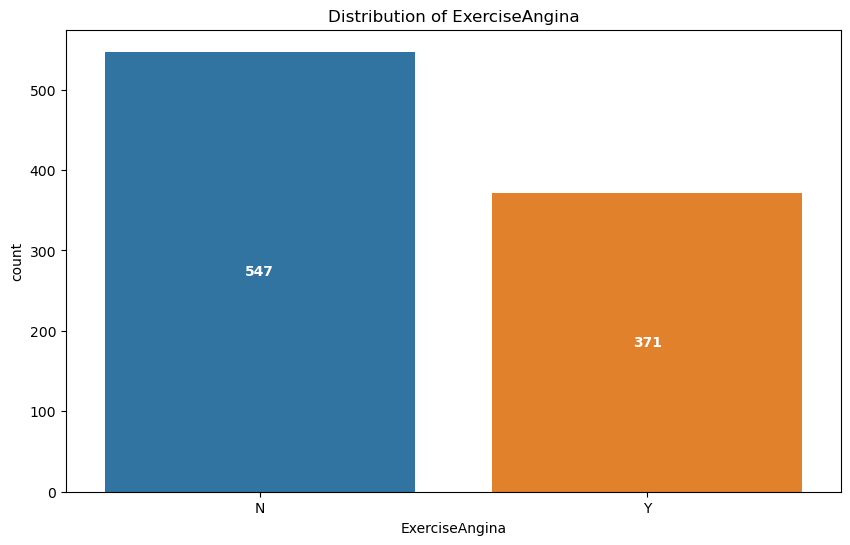

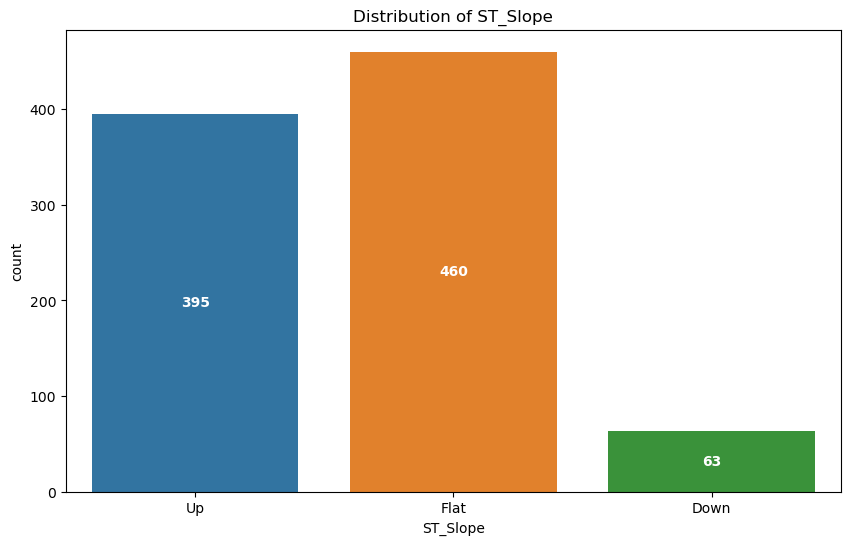

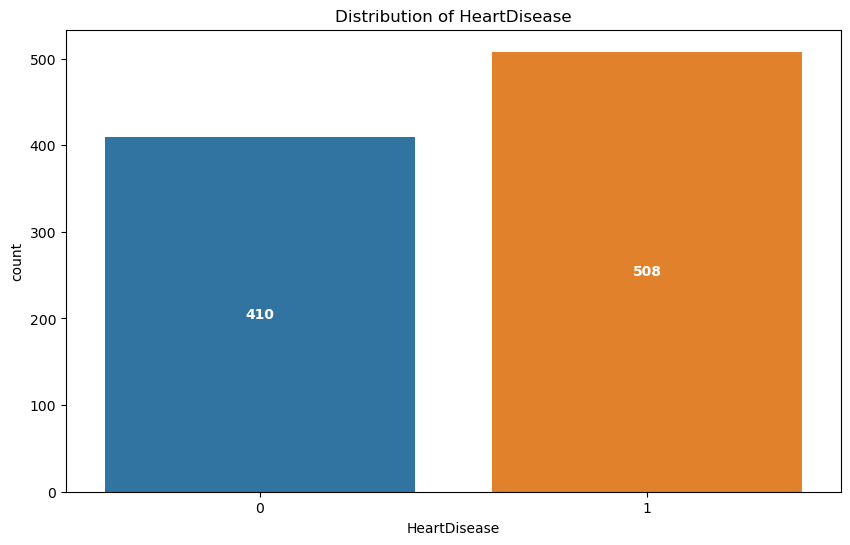

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols  = ['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope','HeartDisease']

for col in cat_cols :
    plt.figure(figsize = (10,6))
    ax = sns.countplot(x=col, data = hdp)
    plt.title(f'Distribution of {col}')
    for container in ax.containers:
        ax.bar_label(container, label_type="center", color='white', weight='bold')
        
    plt.show()
             

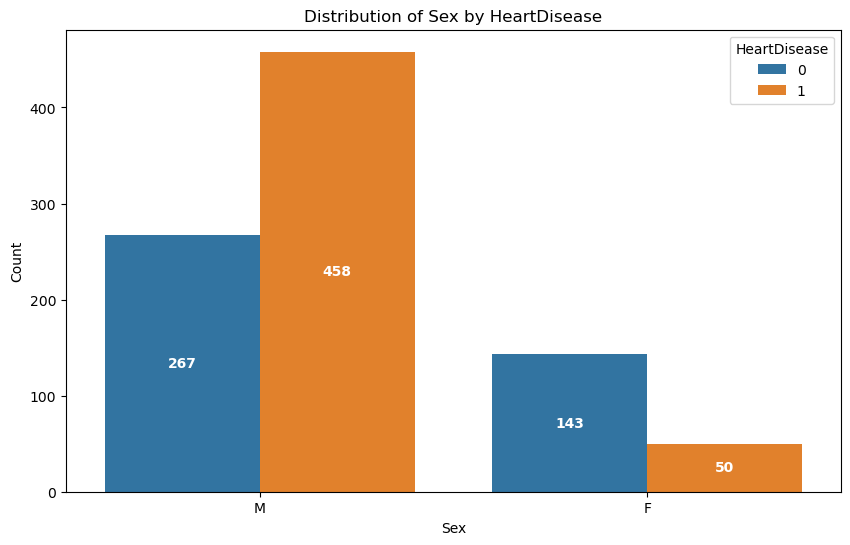

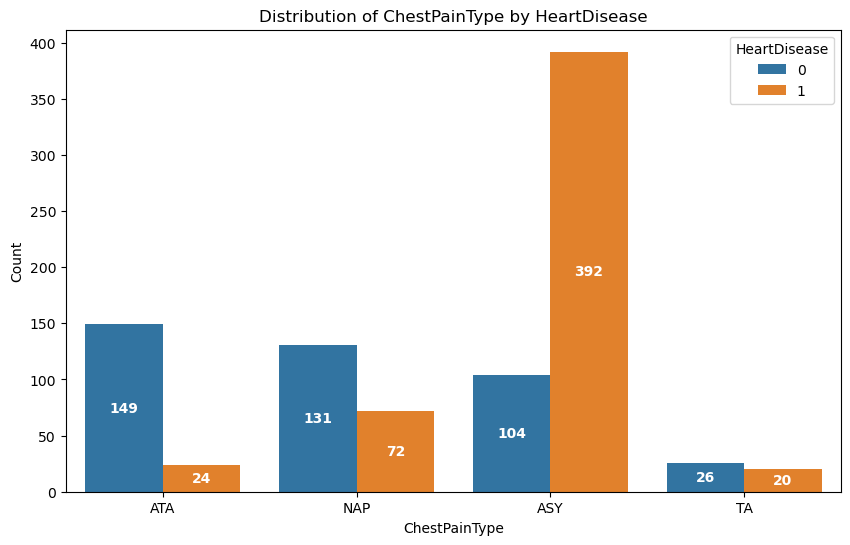

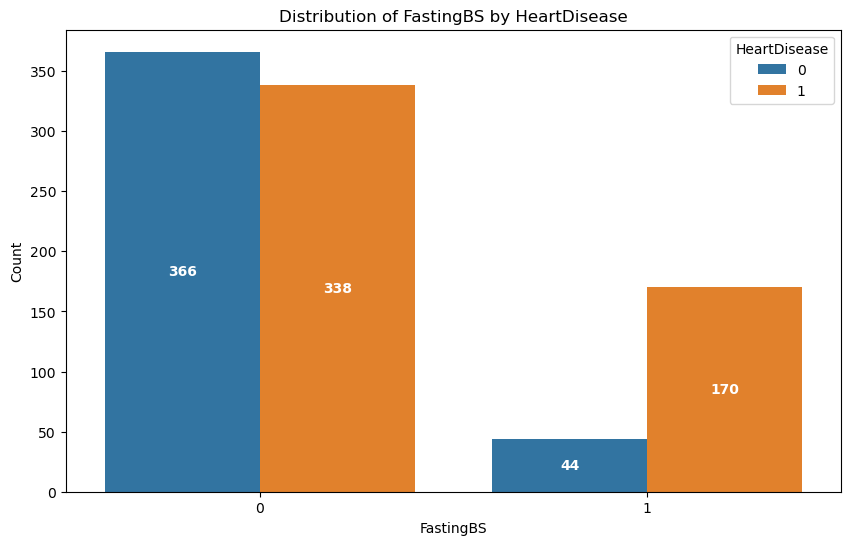

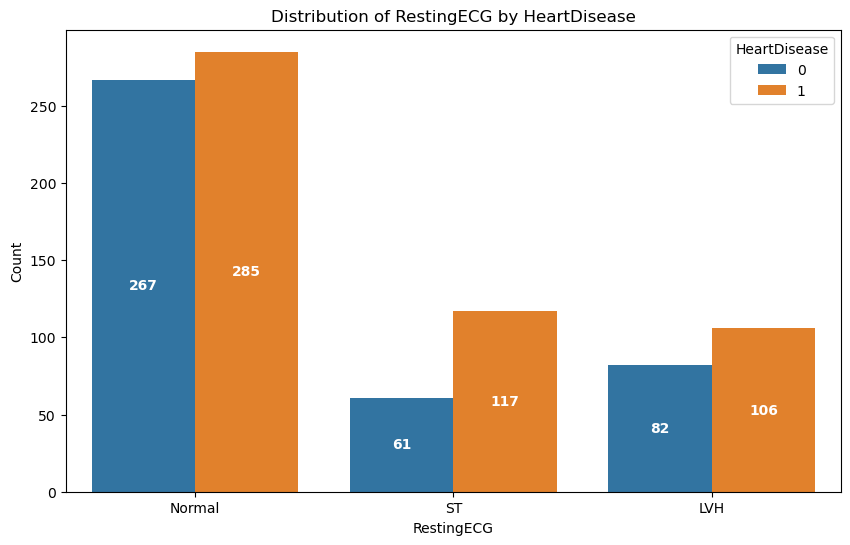

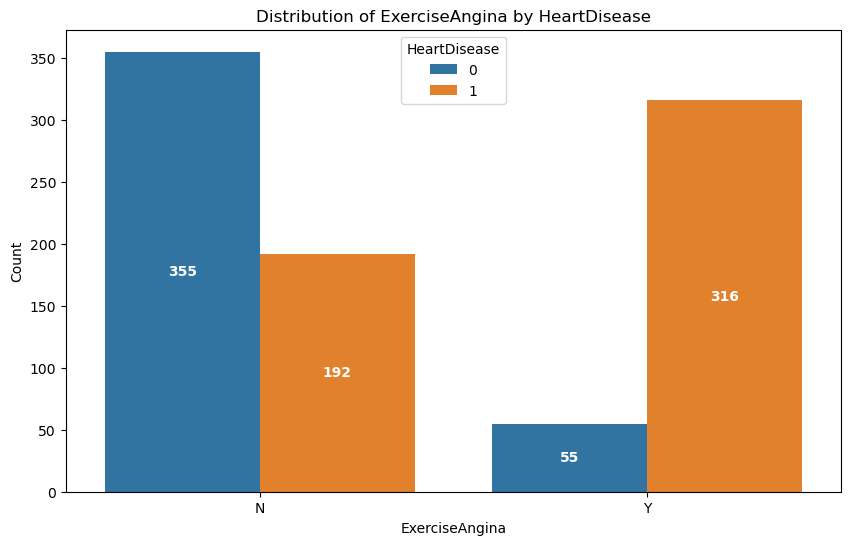

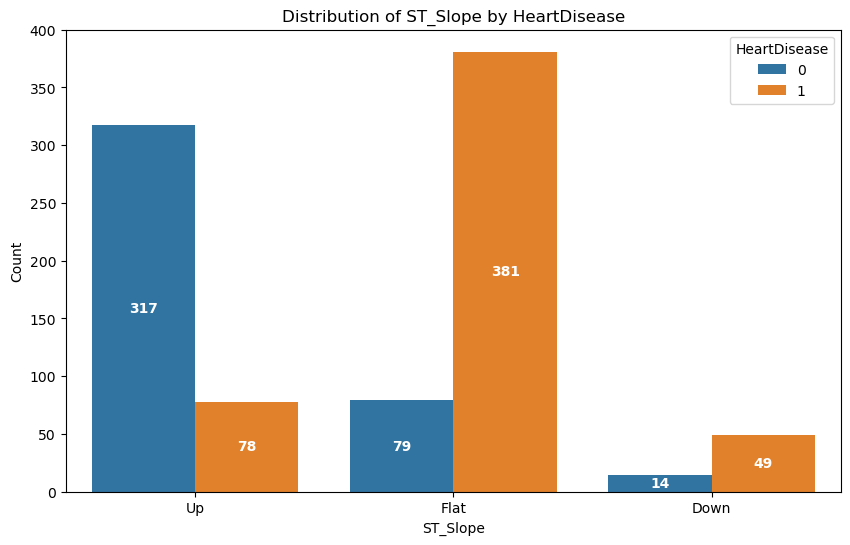

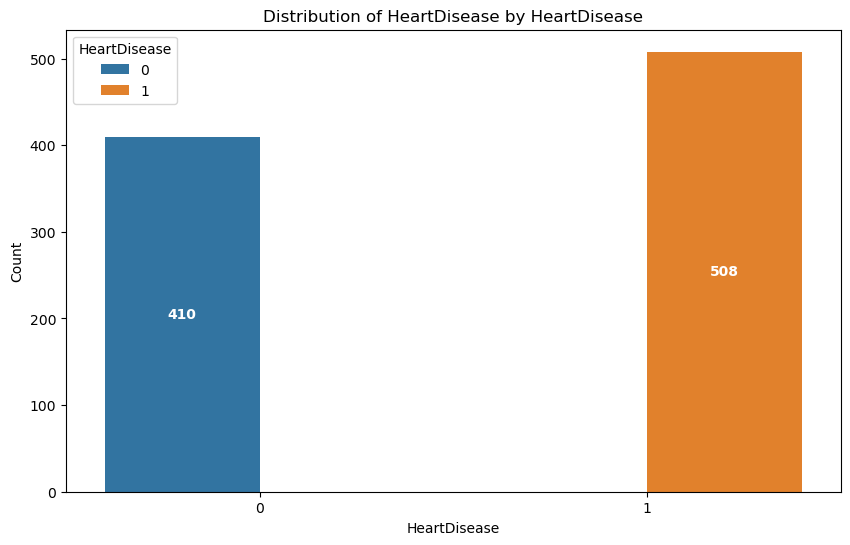

In [28]:

for col in cat_cols:
    plt.figure(figsize=(10,6))
    ax = sns.countplot(x=col, hue='HeartDisease', data=hdp)
    plt.title(f'Distribution of {col} by HeartDisease')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='HeartDisease')
    for container in ax.containers:
        ax.bar_label(container,label_type='center',color = 'white', weight = 'bold')
    plt.show()

Going with the Bargraph we're now able to know that 'ASY' ChestPaintype has higher count for patients with heart disease.

<u><b>Data Cleaning</u></b>

In [29]:
restingbp_0 = hdp[hdp['RestingBP']==0].value_counts().sum()
print(restingbp_0)
chol_0 = hdp[hdp['Cholesterol']==0].value_counts().sum()
print(chol_0)

1
172


In [30]:
print(f'Number of rows that has RestingBP 0 : {restingbp_0}')
print(f'Number of rows that has Cholesterol 0 : {chol_0}')

Number of rows that has RestingBP 0 : 1
Number of rows that has Cholesterol 0 : 172


In [31]:
hdp_copy = hdp.copy()

As we've decided to make changes ie., to remove or replace our columns Cholesterol and RestingBP with 0 values,making a copy of the original dataset when about to make these changes is a must practice so that the original data stays the same regardless of our conclusion. 


In [32]:
#Removing that one row which has 0 value for RestingBP
hdp_copy = hdp_copy[hdp_copy['RestingBP']!= 0]


In [33]:
#Replacing the median value for the column Cholesterol that has 0 value 
hdp_mask = hdp_copy['HeartDisease'] == 0

chol_without_hdp = hdp_copy.loc[hdp_mask,'Cholesterol']
chol_with_hdp = hdp_copy.loc[~hdp_mask,'Cholesterol']

hdp_copy.loc[hdp_mask,'Cholesterol'] = chol_without_hdp.replace(0,chol_without_hdp.median())
hdp_copy.loc[~hdp_mask,'Cholesterol'] = chol_with_hdp.replace(0 ,chol_with_hdp.median())

hdp_copy[['Cholesterol','RestingBP']].describe()



,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


Just as we envisaged ,our min values for both Cholesterol and RestingBp are now changed.And there are no more zero values in these columns 

Now that we've cleaned our data, we can select features that are correlated using Pearson's correlation heatmap. Let's start off with the <b>one-hot encoding</b> for the selected categorical columns

<u><b>Feature Selection<b></u>

In [34]:
hdp_copy = pd.get_dummies(data = hdp_copy ,drop_first = True)
hdp_copy.head(5)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


In [35]:
correlation = abs(hdp_copy.corr())

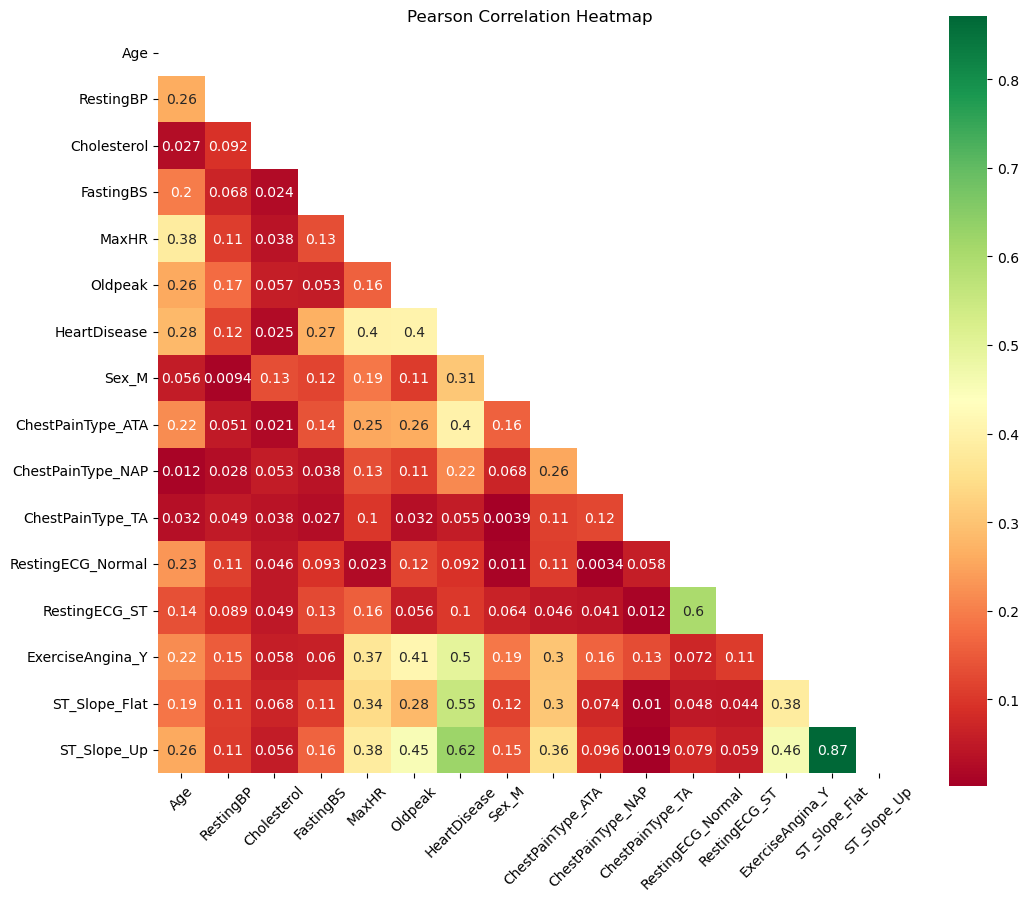

In [36]:
 
plt.figure(figsize=(12,10))
sns.heatmap(correlation, annot=True , cmap = 'RdYlGn',square = True, mask = np.triu(correlation))
plt.xticks(rotation =45)
plt.title("Pearson Correlation Heatmap")
plt.show()

Above is the representation of Pearson Correlation heatmap .The above diagram is interpreted using absolute correlation which eliminates the direction of correlation . For eg - Max Hr has 0.38 but I can eithe be -.38 negatively correlated or 0.38 postively correlated. As we only need the strength of correlation regardless of whether its positive or negative , we've used the abs function to know the strength alone. 

Following are the Features that are correlated to HeartDisease:- ST_slope_Up, ST_slope_Flat, ExerciseAngina_y,Chest_pain_ATA , MaxHR, Oldpeak.
 Although Sex_M has the exact correlation of 0.31 ,we're ignoring it as we can see in our Distribution of sex and Distribution of Sex by HeartDisease where male patients are more in number and are also having HeartDisease , selecting this feature might induce <b>Bias</b> . 

<u><b>Buliding a Classifier with One Feature</u></b>

In [37]:
X = hdp_copy.drop(['HeartDisease'],axis = 1)
y = hdp_copy['HeartDisease']


In [38]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.20 , random_state =417)

features = ['ST_Slope_Up','ST_Slope_Flat', 'ExerciseAngina_Y','ChestPainType_ATA' ,'MaxHR', 'Oldpeak']

for feature in features:
    knn = KNeighborsClassifier(n_neighbors =3)
    knn.fit(X_train[[feature]],y_train)
    accuracy = knn.score(X_val[[feature]],y_val)
    print(f"The model Accuracy of the {feature} with k=3 is : {accuracy*100:.2f}%")

The model Accuracy of the ST_Slope_Up with k=3 is : 80.98%
The model Accuracy of the ST_Slope_Flat with k=3 is : 78.26%
The model Accuracy of the ExerciseAngina_Y with k=3 is : 71.20%
The model Accuracy of the ChestPainType_ATA with k=3 is : 44.02%
The model Accuracy of the MaxHR with k=3 is : 54.89%
The model Accuracy of the Oldpeak with k=3 is : 70.65%


As the best performing model being ST_Slope_Up with 80.98 % accuracy and the second best being ST_Slope_Flat with 78.26% , Our focus now should be in improving our model's accuracy. Let's train multiple features now and observe the accuracy on the validation set

In [45]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])
knn = KNeighborsClassifier(n_neighbors =3)
knn.fit(X_train_scaled,y_train)
accuracy = knn.score(X_val_scaled,y_val)
print(f"The Accuracy of the model on the validation set is :{accuracy*100:.2f}%")

The Accuracy of the model on the validation set is :80.98%


The validation set's Accuracy is the same as the best accuracy from the training set ST_Slope_Up.To further improve our accuracy lets try tuning the hyperparameters.

<b><u>HyperParameter Optimization</b></u>

GridSearchCV enables us to explore various parameters for our classifier. For instance, with the KNeighborsClassifier, we can experiment with parameters such as n_neighbors, weights, metric, and more. Since GridSearchCV generates its own validation set during the process, we need to adjust our workflow accordingly.

Now let's split the hdp_copy dataset into training and validation sets again.

In [57]:
X = hdp_copy.drop(["HeartDisease"], axis=1)
y = hdp_copy["HeartDisease"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=417)

features = ['ST_Slope_Up','ST_Slope_Flat', 'ExerciseAngina_Y','ChestPainType_ATA' ,'MaxHR', 'Oldpeak']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

grid_params = {'n_neighbors':range(1,30),'metric':['minkowski','manhattan']}

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn,grid_params,scoring ='accuracy')
knn_grid.fit(X_train_scaled,y_train)

print(f'Best Score {knn_grid.best_score_*100:.2f}%')
print(f'Best parameter {knn_grid.best_params_}')






Best Score 83.70%
Best parameter {'metric': 'minkowski', 'n_neighbors': 26}


This model achieved an accuracy of 83.70% with 26 neighbors and minkowski as the distance metric.

The accuracy of this model is better than the previous one (80.98%). Since GridSearchCV employs a cross-validation approach, it provides a more reliable estimate of the model's performance compared to our previous attempt.

<u><b>Model Evaluation On Test set</u></b>

In [58]:
X_test_scaled = scaler.transform(X_test[features])

predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(predictions,y_test)
print(f"Model Accuracy on test set {accuracy*100:.2f}%")

Model Accuracy on test set 83.33%


Our model achieved an impressive accuracy of 83.23% on the test dataset, which means it is likely to correctly predict whether a patient is at risk of heart disease around 83.33% of the time.

<u><b>Conclusion</u></b>

We roleplayed that we are working for an R&D company that focuses on providing healthcare solutions. The company has collected anonymized data from multiple hospitals on several patients. The dataset includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before.

We used the K-nearest Neighbors algorithm to predict the likelihood of a new patient having a heart disease.
And so we realized that the following steps were involved in using this algorithm:
1) Reading the data and identifying the number of numerical & categorical features
2) Displayed Descriptive Statistics to observe the data
3) Visualized the Data and also grouped it by our target feature (HeartDisease)
4) Cleaned up all the data by either removing or replacing based on their volume inorder to proceed with Feature Selection
5) Selected Features using Pearman Correlation Heatmap that showed us the correlation between the other features and the target feature.
6) Built Classifier with one and multiple features to test the accuracy 
7) Tuned Hyperparameters using GridSearchCV which cross-validates and cross-checks and to ascertain the Model's Best Score with Best parameters
8) Evaluated the model on Test set and got an accuracy of 83.33% ensuring that the Test set accuracy is not more or less 1-5% than the training set accuracy(80.98%) , which would then imply that our model is <b>Over-fitting</b> or <b>Under-fitting</b>.

With this, we can conclude that our model achieved a whooping accuracy of 83.33%, which means it is likely to predict correctly whether a new patient is at risk of heart disease approximately 83.33% of the time.
